<a href="https://colab.research.google.com/github/cherryng/MLcourse/blob/main/H3_Regression_and_Classification_(student_version).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

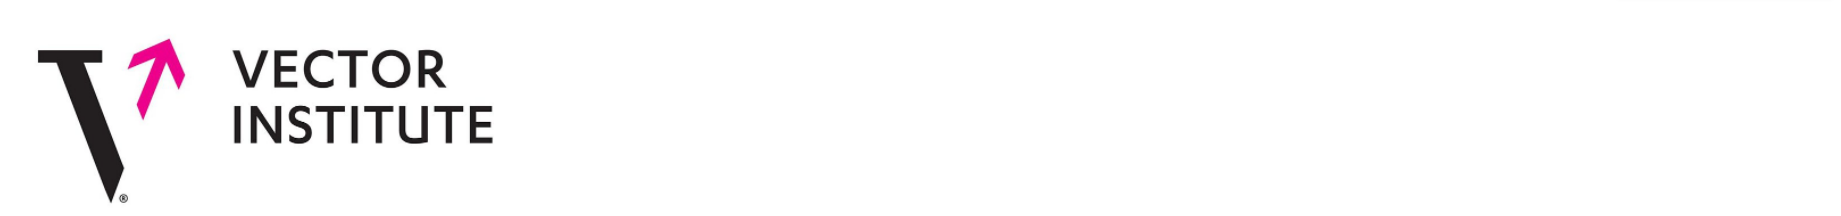


# Homework 3 - Regression Models

We will be exploring an medical cost dataset with various demographic and health information on patients. We can tackle 2 main ideas in supervised learning: (1) regression and (2) classification.

1.   For a regression task, the goal is to predict **medical costs** (based on insurance claims) using a linear regression model. 
2.   For a (binary) classification task, the goal is to predict if the insurance beneficiary is a **smoker or a non-smoker** with a logistic regression model.

In [1]:
# Import relevant Python packages
import matplotlib.pyplot as plt        # visualization
import numpy as np                     # matrices and high-level math functions
import pandas as pd                    # data manipulation
import seaborn as sns                  # visualization (based on matplotlib)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from scipy import stats                # scientific computing
# sklearn is a popular machine learning library
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from yellowbrick.cluster import KElbowVisualizer # visualize optimal number of clusters

## Import Dataset

In [2]:
# Load the dataset into a pandas dataframe
url = 'https://raw.githubusercontent.com/salexyun/Michener-AI-for-Clinician-Champions/main/medical_cost.csv'
df = pd.read_csv(url)

In [3]:
# Look at the first 5 rows in the dataset
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We have just read a comma-separated values (csv) file into a pandas data structure called DataFrame. This allows us to input the case study data into this programming environment.



## Exploratory Data Analysis (EDA)

Let's explore the dataset by looking at its dimension (number of rows and columns), the data types of each feature, and whether there are any missing datapoints in the dataset.  These are typical ways to gain an initial understanding of a dataset using simple Python functions.

In [4]:
# Print out the number of rows and columns in the dataset
print("Dimensionality of the DataFrame:", df.shape)

Dimensionality of the DataFrame: (1338, 7)


In [5]:
# Print out summary statistics for each variable in the dataset
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
# Print out the data type of each feature in the dataset
print("Data type of each feature:")
df.dtypes

Data type of each feature:


age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [7]:
# Determine if there are any missing datapoints or duplicate rows in the dataset
print("\nAre there any missing datapoints in the dataset?", df.isnull().values.any())
print("Number of duplicated rows:", df.duplicated().sum())


Are there any missing datapoints in the dataset? False
Number of duplicated rows: 1


There are 1338 individual datapoints with 7 columns or features in the dataset:
- age: age of the primary beneficiary
  - ratio (continuous variable)
- sex: sex of the beneficiary (male or female)
  - nominal (categorical variable)
- bmi: body mass index; a value derived from the mass and height of the beneficiary
  - interval (continuous variable)
- children: number of children covered by the insurance
  - ratio (discrete variable)
- smoker: whether the beneficiary smokes or not (yes or no)
  - nominal (categorical variable)
- region: residential area of the beneficiary in the U.S.
  - nominal (categorical variable)
- charges: individual medical costs billed by the insurance
  - ratio (continuous variable)

**int64** refers to integer numbers; **float64** refers to floating point numbers; and **object** refers to texts or alphanumeric values.

Luckily there are no missing datapoints in the dataset. Missing data can be problematic when carrying out data analysis. To combat this, we can either drop the entire row or use data imputation strategies where the missing value is replaced by a substituted value.

There is one duplicated row and will be removed accordingly.

In [8]:
# Remove the duplicate row from the dataset
df.drop_duplicates(keep='first', inplace=True)

In [9]:
# Confirm the final number of rows and columns in the dataset after data cleaning
print("df.shape =", df.shape)
print("Number of rows =", df.shape[0])
print("Number of columns =", df.shape[1])

df.shape = (1337, 7)
Number of rows = 1337
Number of columns = 7


### Data visualization

In addition to the descriptive statistics, visualizing the distribution of the data can provide additional information on the data itself and can guide us in how to carry out the analysis appropriately.

(0.8147611021995544, 1.1960358168550093e-36)


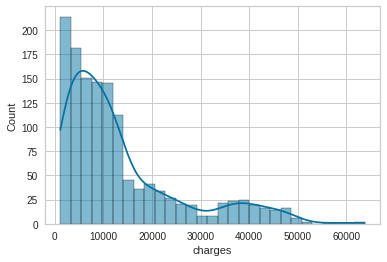

In [10]:
# Plot a histogram representing the distribution of the "charges" variable
sns.histplot(df['charges'], kde=True)
print(stats.shapiro(df['charges']));

The distribution appears to be non-Gaussian and positively skewed (or right skewed). We can formally test the normality with the Shapiro–Wilk test and can confirm that the distribution is indeed not normal.

***Note, normality is a condition for regression models.

While it is not always necessary to transform data, it often helps with interpretability and to meet certain assumptions for statistical inference. In our case, we will be using the Box-Cox transformation.

Text(0.5, 0, 'charges (transformed)')

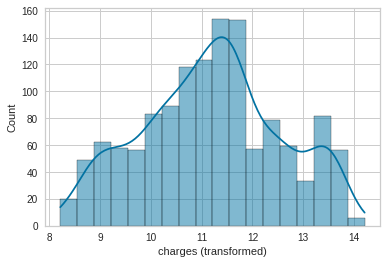

In [11]:
# Transform the target variable to a normal distribution
charges_transformed = stats.boxcox(df['charges'])[0]
sns.histplot(charges_transformed, kde=True);
plt.xlabel('charges (transformed)')

One of the major assumptions of linear regression is that there should be little to no multicollinearity; that is, independent variables should be relatively independent from one another.

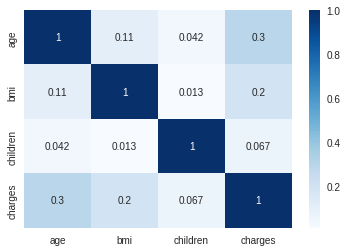

In [12]:
# Use a heatmap to check for collinearity between variables
# A higher (darker) value represents higher correlation between two variables
# A lower (lighter) value represents lower correlation between two variables
sns.heatmap(df.corr(), cmap='Blues', annot=True);

Correlation coefficient values below 0.3 are considered to be weak; 0.3-0.7 are moderate; >0.7 are strong. In this case, all correlations are 0.3 or below, so we can conclude that the variables are independent from one another.

***Independence of variables is a condition for regression.

We can now move on to visualizing the independent variables (these are the features of your dataset).


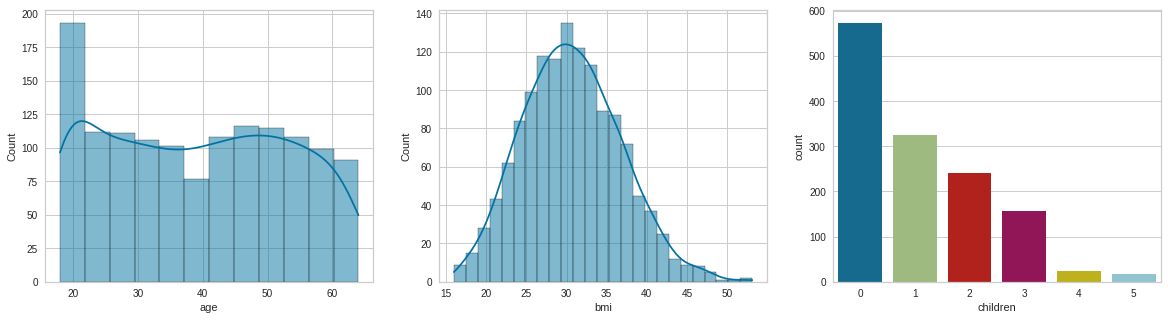

In [13]:
# Plot the distribution of age, BMI, and number of children
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,5))
sns.histplot(x=df['age'], kde=True, ax=ax0);
sns.histplot(x=df['bmi'], kde=True, ax=ax1);
sns.countplot(x=df['children'], ax=ax2);

Using prior knowledge, we may be able to come up with a few hypotheses. In particular, older individuals and/or individuals with higher BMI would likely to have more ailments, and thus may incur higher medical costs.

***Correlation is different from causation. We are not establishing causal relationships between variables. 

While BMI is a continuous variable, it is often described as a (ordinal) categorical variable with the following categories: (1) underweight; (2) normal weight; (3) overweight; and (4) obese. As such, we can create a new feature accordingly.

In [14]:
# Create a new feature for BMI based on categories (underweight, normal weight, overweight, obsese)
conditions = [(df['bmi'] < 18.5),
              (df['bmi'] >= 18.5) & (df['bmi'] < 25),
              (df['bmi'] >= 25) & (df['bmi'] < 30),
              (df['bmi'] >= 30)]
labels = ['underweight', 'normal weight', 'overweight', 'obese']
df['bmi_categories'] = np.select(conditions, labels)
df.head()

,age,sex,bmi,children,smoker,region,charges,bmi_categories
0,19,female,27.900,0,yes,southwest,16884.92400,overweight
1,18,male,33.770,1,no,southeast,1725.55230,obese
2,28,male,33.000,3,no,southeast,4449.46200,obese
3,33,male,22.705,0,no,northwest,21984.47061,normal weight
4,32,male,28.880,0,no,northwest,3866.85520,overweight


Now let's explore the relationship between the independent variables (age, bmi, children) and the target variable (charges).

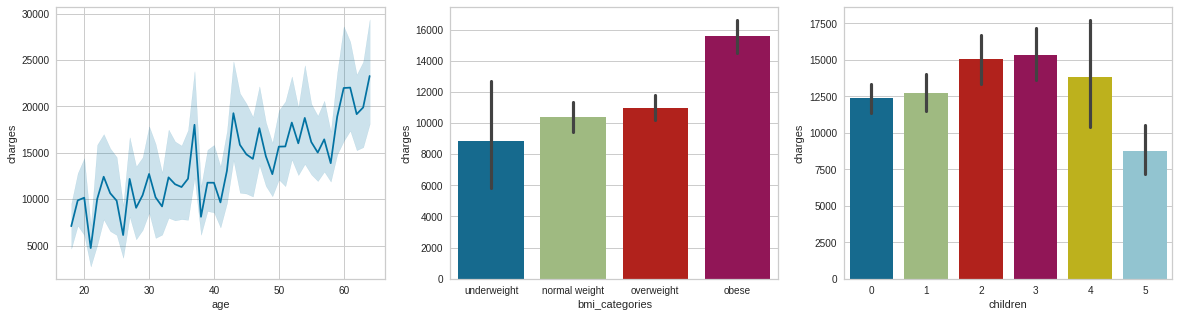

In [16]:
# Plot the relationship between the independent variables (age, bmi_categories, children)
# and the dependent/target variable (charges)
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,5))
sns.lineplot(x='age', y='charges', data=df, ax=ax0);
sns.barplot(x='bmi_categories', y='charges', data=df,
            order=['underweight', 'normal weight', 'overweight', 'obese'], ax=ax1);
sns.barplot(x='children', y='charges', data=df, ax=ax2);

As we suspected, medical cost tends to increase as a function of age or bmi. On the other hand, it is difficult to draw any conclusion regarding the medical costs based on the number of children/dependents that the beneficiary has. Let us examine rest of the independent variables.

## 3.A


---

**Question 3A** 

1.   Plot the distribution of independent variables "sex", "smoker" and "region" 
2.   Plot the relationship between the independent variables (sex, smoker, region) and the dependent/target variable (charges) 

---



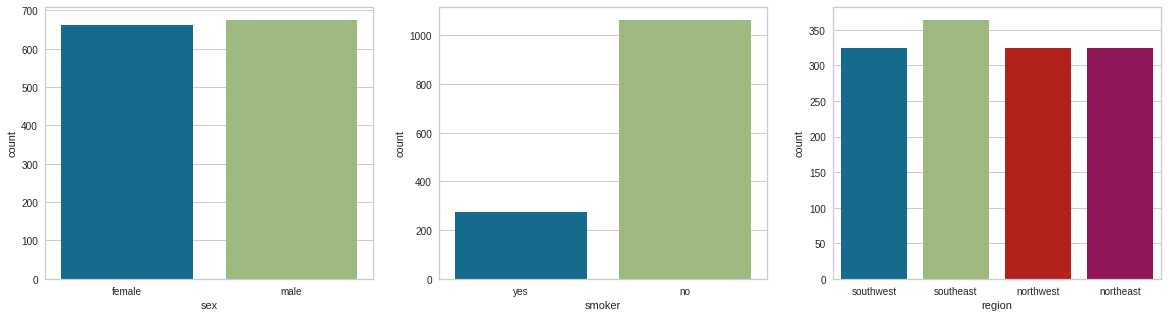

In [22]:
# Plot the distribution of the remaining three independent variables: sex, smoker, region
# Hint: Use sns.countplot for all three of the variables since they are all categorical
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,5))
sns.countplot(x='sex', data=df, ax=ax0);
sns.countplot(x='smoker', data=df, ax=ax1);
sns.countplot(x='region', data=df, ax=ax2);

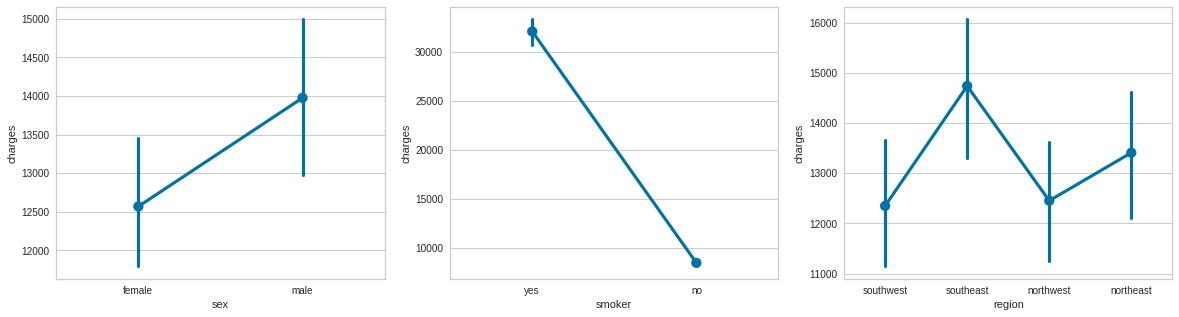

In [23]:
# Plot the relationship between the independent variables (sex, smoker, region)
# and the dependent/target variable (charges)
# Hint: Use sns.pointplot for all three of the variables -- the syntax of pointplot is similar to sns.lineplot

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,5))
sns.pointplot(x='sex', y='charges', data=df, ax=ax0);
sns.pointplot(x='smoker', y='charges', data=df, ax=ax1);
sns.pointplot(x='region', y='charges', data=df, ax=ax2);

Initial thoughts on above plots:
- It appears that there may be sex differences in the medical costs; in particular, male, on average, spends more on medical procedures.  However, since the error bars do overlap, we cannot make a solid conclusion.
- Not surprisingly, medical costs are likely to be higher for smokers, compared to non-smokers.
- Interestingly, where one lives seems to have an effect on the medical costs. Most likely due to the differences in the state law, healthcare policies, and lifestyle of individuals living in different regions within the U.S.

## Preprocessing

Given that we wish to use a regression model and some of the features are non-numeric, we must transform them via feature encoding. There are several encoding strategies and can vary depending on the nature of the feature (i.e., nominal vs. ordinal). In our case, we will be using a simple label encoder that turns the target labels to values between 0 and n_classes-1.

In [ ]:
# Transform categorical variables to numerical values and create a new variable 
# to store each of the encoded values
encoder = LabelEncoder()
df['sex_encoded'] = encoder.fit_transform(df['sex'])
df['smoker_encoded'] = encoder.fit_transform(df['smoker'])
df['region_encoded'] = encoder.fit_transform(df['region'])
df['charges_transformed'] = stats.boxcox(df['charges'])[0]
df.head()

In [ ]:
# Let's look at the number of columns we have now after data preprocessing
df.columns

Instead of the original 7 columns, we now have 12 columns.  Since some of these new variables that were created are simply numerical representations of the original variables, in the next section we will drop the duplicated features before training the model.

## Modelling

We have more or less completed the heavy lifting already. Contrary to popular belief, most of data science and AI (machine learning) is about exploring data and feature engineering (i.e., cleaning up data). That said, we are ready to define the model, train the model, make predictions, and evaluate the performance of our model.

### Linear regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In this section, we will build a Linear Regression model to predict the amount of charges (medical costs) based on an individual's age, BMI, number of children, sex, whether they are a smoker, and what region they live in.



#### Build the model

We will first split the dataset into different datasets: (1) training set; and (2) test set. When we develop a model, we train the model using the samples in the training set. Once the model has learned, we evaluate the performance of our model with the samples in the test set. By testing on unseen data, we minimize the bias of our model and can accurately estimate the generalizability and predictive power of our model. Here, we will split the dataset into 90% training set and 10% test set. Other typical splits includes 70-30 split, 80-20 split, etc.

In [ ]:
# Define X (features) and y (target) and remove duplicate features that will not be used in the model
X = df.drop(['sex', 'smoker', 'region', 'charges', 'bmi_categories', 'charges_transformed'], axis=1)
y = df['charges_transformed']
X.head()

# Split the dataset into X_train, X_test, y_train, and y_test
# Retain 10% of the data for testing, and use a random state value of "0"
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0) 

In [ ]:
# Instantiate a linear regression model
linear_model = LinearRegression() 

# Fit the model using the training data
linear_model.fit(X_train, y_train) 

# Print out the intercept and coefficients for the linear regression model
print(linear_model.intercept_)
print(linear_model.coef_)

#### Make predictions

We will now make predictions on data (test set) that was not part of the training.

In [ ]:
# For each record in the test set, make a prediction for the y value (transformed value of charges)
# The predicted values are stored in the y_pred array
y_pred = linear_model.predict(X_test)

## 3.B



---


**Question 3B** 

Common metrics that are used to evaluate the performance of a linear regression model include Mean Squared Error (MSE), Mean Absolute Error (MAE) and the coefficient of determination (R^2).

Derive the values for MSE, MAE and R^2 using Python's math library, based on the equations shown below.

Helpful hints: 

* y_test: The actual values of y in the test set
* y_pred: The predicted values of y ("y-hat") in the test set
* n: The number of records in the test set

Python tips:
* To square a value: x**2
* To take the sum of a set of values: sum(x)
* To take the mean of a value: x.mean()
* To take the absolute value: abs(x)
* To get the number of items in an array: len(x)

Remember to use proper brackets ( ) to ensure proper order of operations!


---










#### Model evaluation

Mean Squared Error $(MSE) = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$

Mean Absolute Error $(MAE) = \frac{1}{n} \sum_{i=1}^{n} \lvert y_i - \hat{y_i} \rvert$

Both MSE and MAE represent the difference between the actual values and predicted values. Lower value indicates a better fit.

$R^2 = 1 - \frac{RSS}{TSS}$, where

$RSS=\sum_i (y_i - \hat{y})^2=$ sum of squares of residuals ("Residual Sum of Squares")

$TSS=\sum_i (y_i - \bar{y})^2=$ total sum of squares ("Total Sum of Squares")

The coefficient of determination ($R^2$) is a measure of how well the model fits the dependent variable. The value ranges from 0 to 1; higher value indicating a better fit. R Squared may also be expressed as a percentage.

In [ ]:
# Derive the MSE, MAE and R^2 values using Python math library

'''
COMPLETE THE CODE HERE

MSE = ?
MAE = ?
RSS = ?
TSS = ?
R_squared = ?

print("Mean squared error (MSE) =", MSE)
print("Mean absolute error (MAE) =", MAE)
print("R^2 =", R_squared)
'''


Compare your results with the calculated values below using the metrics package in Python.  They should be the same.

In [ ]:
# The metrics package in Python can derive the model evaluation metrics
print("Mean squared error (MSE) =", metrics.mean_squared_error(y_test, y_pred))
print("Mean absolute error (MAE) =", metrics.mean_absolute_error(y_test, y_pred))
print("R^2 =", metrics.r2_score(y_test, y_pred))

A R^2 value of 83% indicates that our model can explain 83% of the variance in the data, so it performs quite well!

**What does this mean?**
The results of this model show that by taking specific attributes of an individual such as their age, BMI, number of children, sex, whether they are a smoker or non-smoker, and region where they live, we can predict the approximate amount of medical costs (based on insurance claims) the individual is likely to incur.

## 3.C



---


**Question 3C** 

1.   Split the dataset into train and test sets
2. Instantiate a Logistic Regression model and name it "logit_model"
2.   Fit the logistic regression model using the training data


---



### Logistic regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Moving on to the classification problem; we will try to predict if the insurance beneficiary is a smoker or a non-smoker with a logistic regression.

#### Build the model

In [ ]:
# Select the features to be used in this model and define the categorical target variable (smoker_encoded)
X = df[['age', 'bmi', 'children', 'sex_encoded', 'region_encoded', 'charges_transformed']]
y = df['smoker_encoded']
X.head()

In [ ]:
# 1. Split the data into X_train, X_test, y_train, y_test, retaining 10% of the data for testing, with random state='0'
# 2. Instantiate a Logistic Regression model and name it "logit_model"
# 3. Fit the logistic regression model with the training data

'''
COMPLETE THE CODE HERE
'''


#### Make predictions

We will now make predictions on data (test set) that was not part of the training.

In [ ]:
y_pred = logit_model.predict(X_test)

## 3.D


---


**Question 3D** 

Derive the Precision, Recall and F1 Scores for the logistic regression model using Python's math library, based on the confusion matrix and equations shown below.



---


#### Model evaluation

For a classification task, it is often useful to visualize using the confusion matrix. Recall in confusion matrix:

![](https://drive.google.com/uc?export=view&id=1Q_MMvu6lO5Gr6WmzIsf_sK__gU1qAzzG)

- tn (True Negative): correct absence of result
- fp (False Positive): unexpected result (type I error)
- fn (False Negative): missing result (type II error)
- tp (True Positive): correct result

We can utilize several metrics including precision, recall, and $F$ measure:
$$\text{precision} = \frac{tp}{tp + fp}$$
$$\text{recall} = \frac{tp}{tp + fn}$$
$$F_1 = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}$$

**Precision**: "Precision" is the ratio of correctly predicted positive observations to the total predicted positive observations. The question that this metric answer is: *Of all individuals that were predicted to be smokers, how many are actually smokers?*

**Recall**: "Recall" is the ratio of correctly predicted positive observations to all observations in the actual class. The question recall answers is: *Of all the individuals that were actually smokers, how many did we predict to be smokers?*

**F1 score:** "F1 Score" is the weighted average of Precision and Recall.

In [ ]:
# Generate the Confusion Matrix for this logistic regression model
cm = metrics.confusion_matrix(y_test, y_pred, labels=logit_model.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logit_model.classes_)
disp.plot(cmap='Blues')
plt.show()


Helpful hints on how to interpret the confusion matrix: 

*   True Negative (tn): Both the predicted label and the true label are 0
*   False Positive (fp): The predicted label is 1 but the true label is 0
*   False Negative (fn): The predicted label is 0 but the true label is 1
*   True Positive (tp): Both the predicted label and the true label are 1


In [ ]:
# Given the information in the confusion matrix, derive the Precision, Recall and F1 Score 
# for this model using the equations provided above
'''
COMPLETE THE CODE HERE

tn = ?
fp = ?
fn = ?
tp = ?

precision = ?
recall = ?
f1_score = ?

# Print out the performance metrics, rounded to 2 decimal points
print("Precision =", round(precision, 2))
print("Recall =", round(recall, 2))
print("f1_score =", round(f1_score, 2))
'''


Compare your results with the calculated values below using the classification_report method in the metrics package.  The values for performance metrics for "smoker" should be the same as what you have derived above.

In [ ]:
print(metrics.classification_report(y_test, y_pred, target_names=['non-smoker', 'smoker']));

Again, our model performs very well!  

**What does this mean?**
The results of this model show that by taking specific attributes of an individual such as their age, BMI, number of children, sex, region where they live, and the medical costs, we can predict whether the individual is likely to be a smoker or a non-smoker.

# Conclusion

Through this coding assignment, you have learned how to:

*   Visualize data in a dataset
*   Plot distributions and relationships
*   Split a dataset into train and test sets
*   Instantiate and fit a Linear and Logistic Regression model
*   Evaluate the results of a Linear Regression model using MSE, MAE and R^2
*   Evaluate the results of a Logistic Regression model using the Confusion Matrix, Precision, Recall and F1 Score



